# House Prices - Advanced Regression Techniques

You have some experience with R or Python and machine learning basics. This is a perfect competition for data science students who have completed an online course in machine learning and are looking to expand their skill set before trying a featured competition. 

## Competition Description

![](https://kaggle2.blob.core.windows.net/competitions/kaggle/5407/media/housesbanner.png)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Practice Skills
* Creative feature engineering 
* Advanced regression techniques like random forest and gradient boosting



In [1]:
%matplotlib inline
import urllib
import zipfile
import os
import seaborn as sns

if not os.path.exists('./data'):
    os.mkdir('./data')

zipfile.ZipFile('all.zip').extractall("./data")

In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Converting Categorical Fields

The below fields have been identified as categorical types, and so will be converted appropriately.

In [3]:
categorical = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageType',
    'GarageFinish',
    'PavedDrive',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition'
]

def conv_categorical(df):
    for cat in categorical:
        df[cat] = df[cat].astype("category")
    return df

train = conv_categorical(train)
test = conv_categorical(test)

## Distribution of Each Field

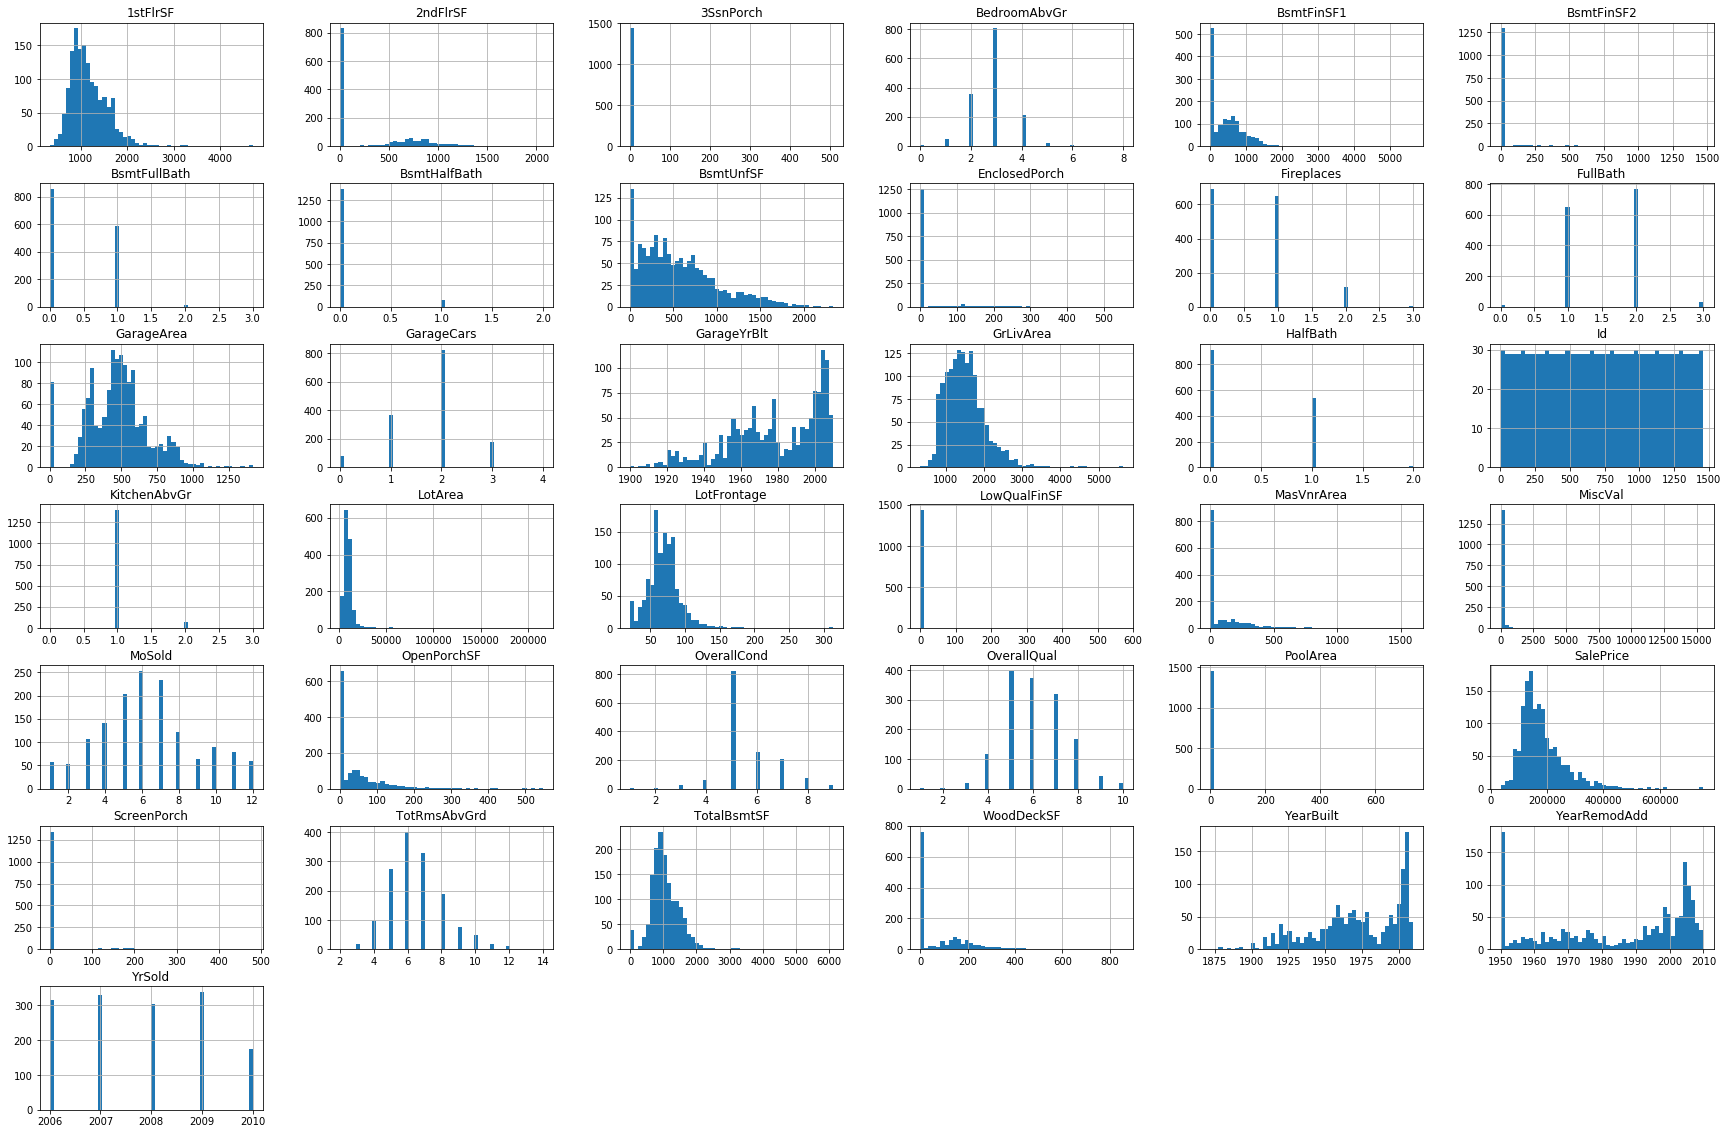

In [4]:
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(30,20))
plt.show()

## Find Correlations with Sale Price

In [5]:
corr_matrix = train.corr()
top_corr = corr_matrix["SalePrice"].sort_values(ascending=False)
top_corr

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

## Outliers - Scatterplot

['SalePrice' 'OverallQual' 'GrLivArea' 'GarageCars' 'GarageArea'
 'TotalBsmtSF' '1stFlrSF' 'FullBath' 'TotRmsAbvGrd' 'YearBuilt']


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


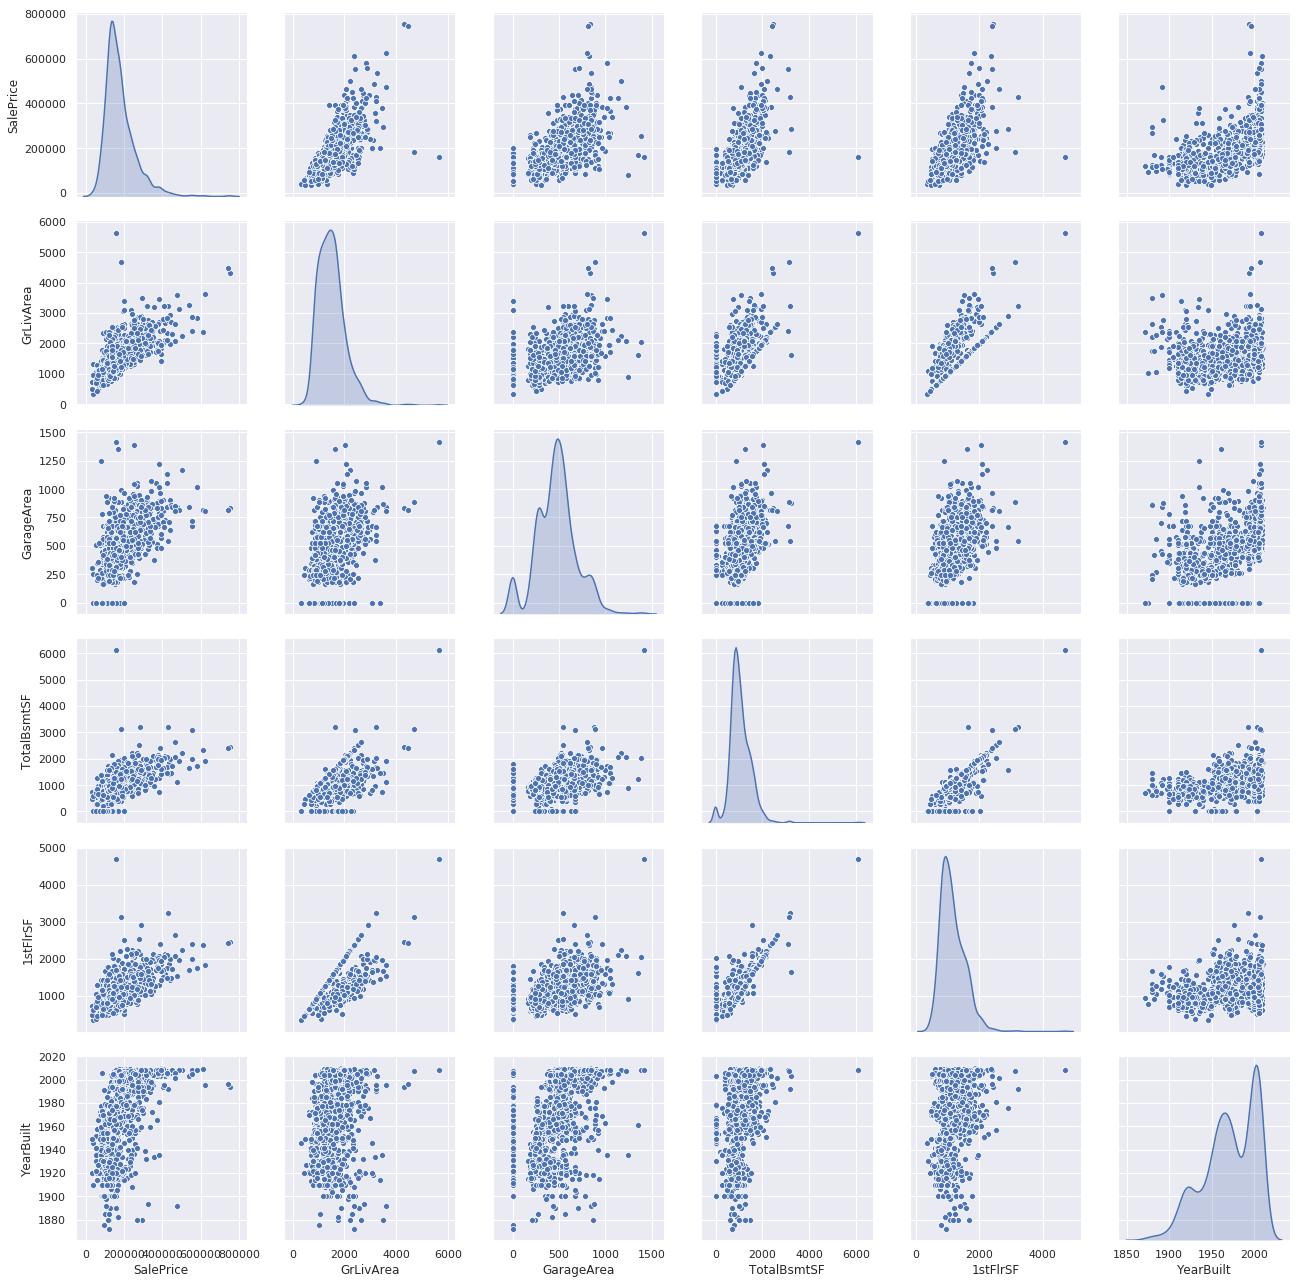

In [6]:
sns.set()
top_ten = top_corr.iloc[:10]
cols = top_ten.index.values
print(cols)
sns.pairplot(train[['SalePrice', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']], height=3, kind='scatter',diag_kind='kde')
plt.show()

Text(0.5,1,'YearBuilt')

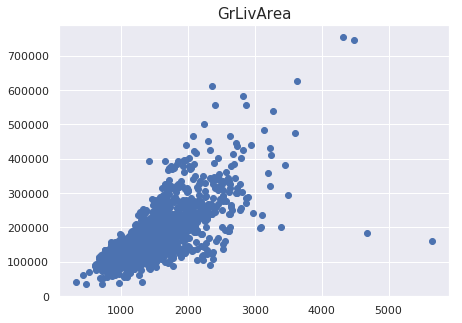

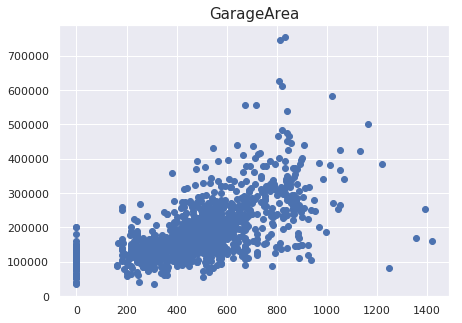

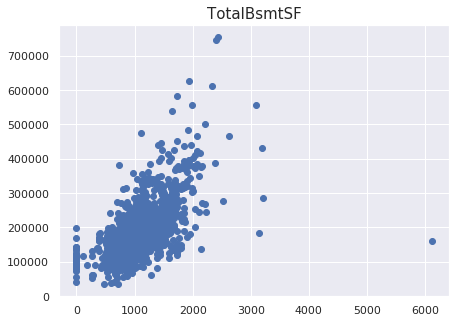

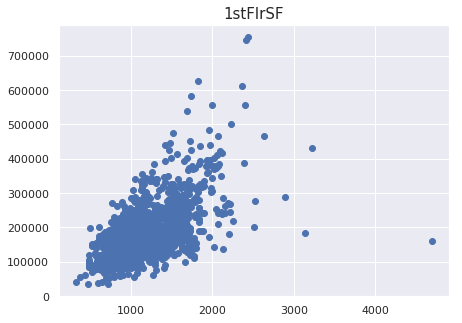

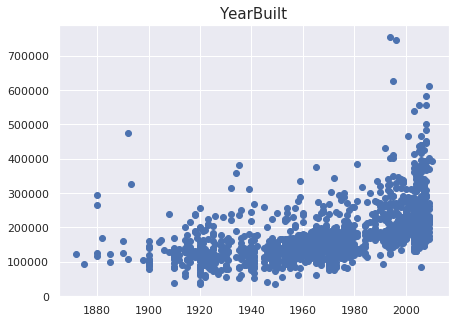

In [7]:
plt.figure(figsize=(7,5))
plt.scatter(x = train.GrLivArea,y = train.SalePrice)
plt.title('GrLivArea', size = 15)

plt.figure(figsize=(7,5))
plt.scatter(x = train.GarageArea,y = train.SalePrice)
plt.title('GarageArea', size = 15)

plt.figure(figsize=(7,5))
plt.scatter(x = train.TotalBsmtSF,y = train.SalePrice)
plt.title('TotalBsmtSF', size = 15)

plt.figure(figsize=(7,5))
plt.scatter(x = train['1stFlrSF'],y = train.SalePrice)
plt.title('1stFlrSF', size = 15)

plt.figure(figsize=(7,5))
plt.scatter(x = train.YearBuilt,y = train.SalePrice)
plt.title('YearBuilt', size = 15)

In [8]:
train.drop(train[train['GrLivArea'] > 5000].index,inplace = True)
train.drop(train[train['GarageArea'] > 1300].index,inplace = True)
train.drop(train[train['TotalBsmtSF'] > 3000].index,inplace = True)
train.drop(train[train['1stFlrSF'] > 3000].index,inplace = True)

## Missing Data

Find features with significant levels of missing data.

In [9]:
missing = train.isna().sum()
to_drop = missing[missing > 500].sort_values(ascending=False)
to_drop_missing = to_drop.index.values
to_drop

PoolQC         1447
MiscFeature    1399
Alley          1362
Fence          1172
FireplaceQu     690
dtype: int64

## Qualitative Data

Some categories fit well with a quality ranking, which provides more information to the algorithm.

In [10]:
qual_map = {
    'ExterQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'ExterCond': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'BsmtQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'BsmtCond': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'BsmtExposure': {
        'Gd': 4,
        'Av': 3,
        'Mn': 2,
        'No': 1
    },
    'HeatingQC': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'KitchenQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'FireplaceQu': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'GarageQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'GarageCond': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1
    },
    'PoolQC': {
        'Ex': 4,
        'Gd': 3,
        'TA': 2,
        'Fa': 1
    }
}

def transform_qual(df):
    for k, v in qual_map.items():
        df[k] = df[k].map(v)
    return df

train = transform_qual(train)
test = transform_qual(test)

## Create Groups of Sales and Plot Hist

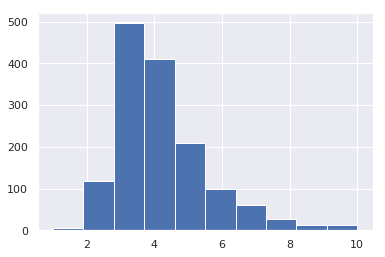

In [11]:
train['SaleBin'] = np.ceil(train['SalePrice']/50000)
train['SaleBin'].where(train['SaleBin'] < 10, 10, inplace=True)
train['SaleBin'].hist()

## Capture Features to Use for Learning

In [12]:
# drop columns with some undefined data
features = train.columns.values
features = features[~np.in1d(features, ["Id", "SalePrice", "SaleBin"])]
features = features[~np.in1d(features, to_drop_missing)]
cat = np.intersect1d(features, np.array(categorical))
non_cat = np.setdiff1d(features, np.array(categorical))
features

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenP

##  Transform Features

In [13]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ("missing", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipeline = Pipeline([
    ("const", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, non_cat),
        ("cat", cat_pipeline, cat),
    ])

full_pipeline.fit(train[features])

all_trans = full_pipeline.transform(train[features])
train_trans = full_pipeline.transform(train[features])
test_trans = full_pipeline.transform(test[features])

assert train_trans.shape[1] == test_trans.shape[1]

## Try RandomForest

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

train_labels = train['SalePrice']

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
        "max_depth": randint(low=1, high=100)
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=5)
rnd_search.fit(all_trans, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_depth=52, max_features=5, n_estimators=15 ...................
[CV]  max_depth=52, max_features=5, n_estimators=15, score=-823834168.5666896, total=   0.1s
[CV] max_depth=52, max_features=5, n_estimators=15 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=52, max_features=5, n_estimators=15, score=-863599282.9886674, total=   0.1s
[CV] max_depth=52, max_features=5, n_estimators=15 ...................
[CV]  max_depth=52, max_features=5, n_estimators=15, score=-1317934554.8697062, total=   0.1s
[CV] max_depth=52, max_features=5, n_estimators=15 ...................
[CV]  max_depth=52, max_features=5, n_estimators=15, score=-779416615.0816246, total=   0.1s
[CV] max_depth=52, max_features=5, n_estimators=15 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=52, max_features=5, n_estimators=15, score=-1449097687.058973, total=   0.1s
[CV] max_depth=72, max_features=5, n_estimators=21 ...................
[CV]  max_depth=72, max_features=5, n_estimators=21, score=-796228177.9440197, total=   0.1s
[CV] max_depth=72, max_features=5, n_estimators=21 ...................
[CV]  max_depth=72, max_features=5, n_estimators=21, score=-811141852.2381965, total=   0.1s
[CV] max_depth=72, max_features=5, n_estimators=21 ...................
[CV]  max_depth=72, max_features=5, n_estimators=21, score=-1240679923.8479478, total=   0.1s
[CV] max_depth=72, max_features=5, n_estimators=21 ...................
[CV]  max_depth=72, max_features=5, n_estimators=21, score=-799120646.7930957, total=   0.1s
[CV] max_depth=72, max_features=5, n_estimators=21 ...................
[CV]  max_depth=72, max_features=5, n_estimators=21, score=-1493166611.2932596, total=   0.1s
[CV] max_depth=83, max_features=7, n_estimators=75 ...................
[CV]  max_dept

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.3s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36ef7b2a20>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36ef7b2550>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36ef7b2d30>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=5)

In [39]:
predictor = rnd_search.best_estimator_
cvres = rnd_search.cv_results_
np.sqrt(-rnd_search.best_score_)

30328.458464911553

## Try Gradient Boosting

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_distribs = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

gradb = GradientBoostingRegressor(loss='ls')
rnd_search = GridSearchCV(gradb, param_grid=param_distribs, cv=5, scoring='neg_mean_squared_error', verbose=3)
rnd_search.fit(all_trans, train_labels)

predictor = rnd_search.best_estimator_
cvres = rnd_search.cv_results_
np.sqrt(-rnd_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] learning_rate=0.001, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.001, n_estimators=100, score=-4819738955.236102, total=   1.0s
[CV] learning_rate=0.001, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=100, score=-5227124109.168917, total=   1.0s
[CV] learning_rate=0.001, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=100, score=-6672021376.971939, total=   1.1s
[CV] learning_rate=0.001, n_estimators=100 ...........................
[CV]  learning_rate=0.001, n_estimators=100, score=-4438328064.291058, total=   1.0s
[CV] learning_rate=0.001, n_estimators=100 ...........................
[CV]  learning_rate=0.001, n_estimators=100, score=-5880878904.023324, total=   1.0s
[CV] learning_rate=0.001, n_estimators=200 ...........................
[CV]  learning_rate=0.001, n_estimators=200, score=-4231874988.7901883, total=   2.1s
[CV] learning_rate=0.001, n_estimators=200 ...........................
[CV]  learning_rate=0.001, n_estimators=200, score=-4588540258.81539, total=   2.0s
[CV] learning_rate=0.001, n_estimators=200 ...........................
[CV]  learning_rate=0.001, n_estimators=200, score=-5903576530.15633, total=   2.0s
[CV] learning_rate=0.001, n_estimators=200 ...........................
[CV]  learning_rate=0.001, n_estimators=200, score=-3884308481.36

[CV]  learning_rate=0.1, n_estimators=200, score=-456439243.66732097, total=   2.0s
[CV] learning_rate=0.1, n_estimators=200 .............................
[CV]  learning_rate=0.1, n_estimators=200, score=-423085771.18047297, total=   1.9s
[CV] learning_rate=0.1, n_estimators=200 .............................
[CV]  learning_rate=0.1, n_estimators=200, score=-683899195.3332238, total=   1.9s
[CV] learning_rate=0.1, n_estimators=200 .............................
[CV]  learning_rate=0.1, n_estimators=200, score=-363844883.3735424, total=   1.9s
[CV] learning_rate=0.1, n_estimators=200 .............................
[CV]  learning_rate=0.1, n_estimators=200, score=-505870723.87505895, total=   2.0s
[CV] learning_rate=0.1, n_estimators=300 .............................
[CV]  learning_rate=0.1, n_estimators=300, score=-455045025.5758808, total=   2.9s
[CV] learning_rate=0.1, n_estimators=300 .............................
[CV]  learning_rate=0.1, n_estimators=300, score=-422101050.1793359, tota

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.0min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


21942.89008569221

Text(0.5,1,'learning_rate')

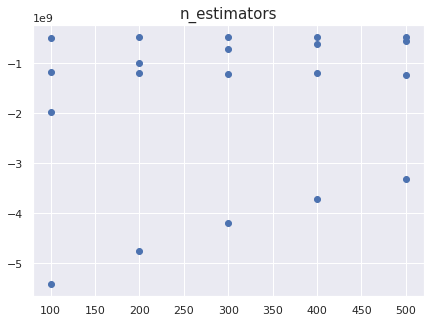

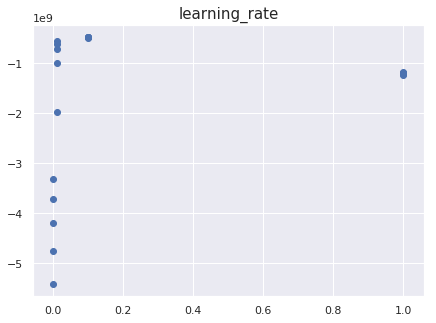

In [61]:
plt.figure(figsize=(7,5))
plt.scatter(x = cvres['param_n_estimators'],y = cvres['mean_test_score'])
plt.title('n_estimators', size = 15)

plt.figure(figsize=(7,5))
plt.scatter(x = cvres['param_learning_rate'],y = cvres['mean_test_score'])
plt.title('learning_rate', size = 15)

## Output Submission

In [62]:
test_trans = full_pipeline.transform(test[features])
test_labels = predictor.predict(test_trans)
results = pd.DataFrame({'Id': test['Id'].values, 'SalePrice': test_labels})
results.to_csv('./results.csv', header=True, index=False)